In [ ]:
!pip install einops


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn

In [ ]:
import numpy as np
from einops import rearrange, repeat


In [ ]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x


In [ ]:
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

In [ ]:
class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

In [ ]:
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1	#residual learning

In [ ]:
class RCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x = self.RCNN(x)
        return x 

In [ ]:
class ResCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(ResCNN_block,self).__init__()
        self.Conv = conv_block(ch_in, ch_out)
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x1 = self.Conv_1x1(x)
        x = self.Conv(x)
        return x+x1 

In [ ]:
class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)


        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [ ]:
model = R2U_Net(img_ch=1,output_ch=1,t=2).cuda()

In [ ]:
print(sum(p.numel() for p in model.parameters()))

39091265


In [ ]:
from IPython.core.display import display, HTML
from string import Template
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from torch.utils.data import DataLoader,Dataset
import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

In [ ]:
import tqdm

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
df = pd.read_csv(path + 'media/train.csv')

In [ ]:
df.head()

,id,name,label,attributes,points,image
0,16,Cr1,9,1,"[[189,308],[188,306],[188,305],[187,303],[187,...",/media/category_52/000078.jpg
1,17,Cr1,9,2,"[[154,303],[154,301],[154,299],[154,297],[154,...",/media/category_52/000079.jpg
2,18,Cr1,9,3,"[[197,319],[194,320],[193,321],[193,323],[193,...",/media/category_52/000080.jpg
3,20,Cr1,9,4,"[[193,329],[196,328],[198,327],[201,326],[203,...",/media/category_52/000081.jpg
4,21,Cr1,9,5,"[[150,283],[152,282],[154,281],[154,280],[156,...",/media/category_52/000082.jpg


In [ ]:
df['name'].unique()

array(['Cr1', 'Cr2', 'Cr3', 'Cr4', 'Cr5', 'Cr6', 'Cr7', 'Cr8', 'Cr9',
       'Cr10', 'large cell carcinoma', 'adenocarcinoma',
       'non-small-cell lung carcinoma', 'squamous cell carcinoma'],
      dtype=object)

In [ ]:
df = df.replace(to_replace =['Cr1', 'Cr2', 'Cr3', 'Cr4', 'Cr5', 'Cr6', 'Cr7', 'Cr8', 'Cr9',
       'Cr10'], value ='adenocarcinoma')

In [ ]:
num = df['name'].unique()

In [ ]:
df

,id,name,label,attributes,points,image
0,16,adenocarcinoma,9,1,"[[189,308],[188,306],[188,305],[187,303],[187,...",/media/category_52/000078.jpg
1,17,adenocarcinoma,9,2,"[[154,303],[154,301],[154,299],[154,297],[154,...",/media/category_52/000079.jpg
2,18,adenocarcinoma,9,3,"[[197,319],[194,320],[193,321],[193,323],[193,...",/media/category_52/000080.jpg
3,20,adenocarcinoma,9,4,"[[193,329],[196,328],[198,327],[201,326],[203,...",/media/category_52/000081.jpg
4,21,adenocarcinoma,9,5,"[[150,283],[152,282],[154,281],[154,280],[156,...",/media/category_52/000082.jpg
...,...,...,...,...,...,...
529,616,adenocarcinoma,20,1,"[[159,347],[163,345],[164,344],[165,343],[167,...",/media/category_153/000033.jpg
530,617,adenocarcinoma,20,2,"[[166,329],[171,325],[175,325],[175,324],[177,...",/media/category_153/000034.jpg
531,618,adenocarcinoma,20,3,"[[184,340],[184,336],[184,332],[185,330],[188,...",/media/category_153/000035.jpg
532,619,adenocarcinoma,20,4,"[[161,344],[165,342],[168,341],[168,340],[174,...",/media/category_153/000036.jpg


In [ ]:
df1 = df
for i in range(len(df['name'])):
    for j in range(len(num)):
        if df['name'][i] == num[j]:
            df1['name'][i] = j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#change string to np array
df['points'] = df['points'].apply(lambda x: np.array(eval(x)), 0)

In [ ]:
dfnew = []

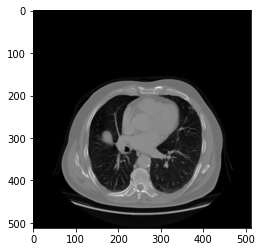

In [ ]:
origImage = cv2.imread(path  + df['image'][0])
origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
plt.imshow(origImage,cmap = "gray")

In [ ]:
from tqdm import tqdm
from matplotlib.path import Path
ar = []
for ind in tqdm(range(len(df['image']))):
    tupVerts= df['points'][ind]


    x, y = np.meshgrid(np.arange(origImage.shape[0]), np.arange(origImage.shape[1])) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(tupVerts) # make a polygon
    grid = p.contains_points(points)
    mask = (grid.reshape(origImage.shape[0],origImage.shape[0])*1).astype('float32') # now you have a mask with points inside a polygon
    mask = cv2.resize(mask, (128,128))
    #mask = grid.reshape(origImage.shape[0],origImage.shape[0])*1
    #mask = grid.reshape([128,128])*1 
    #mask = cv2.resize(mask, (128, 128))
    ar.append(mask)
df['mask'] = ar

100%|██████████| 534/534 [00:35<00:00, 15.23it/s]


In [ ]:
mask.shape

(128, 128)

In [ ]:
origImage.shape[0]

512

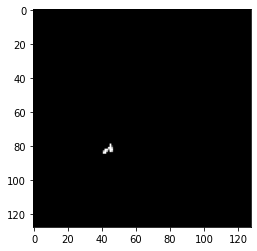

In [ ]:
plt.imshow((mask),cmap = "gray")

In [ ]:
ar = []
for ind in tqdm(range(len(df['image']))):
    origImage = cv2.imread(path  + df['image'][ind])
    origImage = cv2.resize(origImage, (128, 128))
    origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    ar.append(origImage)
df['img'] = ar

100%|██████████| 534/534 [00:03<00:00, 169.50it/s]


In [ ]:
origImage.shape

(128, 128)

In [ ]:
x = []
y = []
z = []
for ind in tqdm(range(len(df))):
    x.append(df['img'][ind])
    y.append(df['mask'][ind])
    z.append(df['name'][ind])

100%|██████████| 534/534 [00:00<00:00, 53454.85it/s]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2, random_state=10)

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
class MyDataset(Dataset):
    def __init__(self, data, targets, label, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.label = label
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        z = self.label[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y, z

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, z_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, z_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  del sys.path[0]


In [ ]:
cnt = 0
temp = 0
for i, batch in enumerate(tqdm(trainloader)):
        X_batch, y_batch, z_batch = batch
        cnt = i
        if i % 2000 == 1999:
            temp += 1 
cnt,temp

100%|██████████| 107/107 [00:00<00:00, 1343.23it/s]


(106, 0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def dice_loss(pred, target):
    pred = torch.sigmoid(pred)

    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = torch.sum(pred * target)
    pred_sum = torch.sum(pred * pred)
    target_sum = torch.sum(target * target)

    return 1 - ((2. * intersection + 1e-5) / (pred_sum + target_sum + 1e-5))

In [ ]:
#!pip install easydict

In [ ]:
epochs = 300 #use 200 
lr = 0.01
decayRate = 0.9

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim import SGD
# loss function
#criterion = nn.CrossEntropyLoss()
criterion = dice_loss
#optimizer = optim.Adam(model.parameters(), lr=lr) 
#optimizer = optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9)
optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
# optimizer
#optimizer = optim.Adam(transunet.parameters(), lr=0.01)

In [ ]:
error = []
test_error = []
for epoch in range(100):       
        for ind, batch in enumerate(trainloader):
          imgs, true_masks, label= batch
          images = imgs
          images = images.to(device=device, dtype=torch.float32)
          #print(images.shape)
          label = label.to(device = device, dtype = torch.long)
          true_masks = (true_masks.to(device=device, dtype=torch.float32))
          #print('true_masks ',true_masks)
          output = model(images)
          #print(output)
          output = torch.squeeze(output,1)
          output = output.to(device=device, dtype=torch.float32)
          loss = criterion(output.squeeze(0), true_masks.squeeze(0))
          #loss = criterion(output, true_masks)
          #if (epoch%10 == 0):
          #print(ind)
          if(ind ==0): 
              error.append(loss.item())              
              #if (epoch%10 ==0):
              #    print(epoch, ' ',loss.item())

          optimizer.zero_grad()
          loss.backward() 
          #nn.utils.clip_grad_value_(model.parameters(), 0.1)
          optimizer.step()
        with torch.no_grad():
          for ind, batch in enumerate(testloader):
            imgs, true_masks, label= batch
            images = imgs
            images = images.to(device=device, dtype=torch.float32)
            #print(images.shape)
            label = label.to(device = device, dtype = torch.long)
            true_masks = (true_masks.to(device=device, dtype=torch.float32))
            #print('true_masks ',true_masks)
            test_output = model(images)
            test_output = torch.squeeze(test_output,1)
            test_output = test_output.to(device=device, dtype=torch.float32)
            test_loss = criterion(test_output.squeeze(0), true_masks.squeeze(0))
            if(ind ==0): 
              test_error.append(test_loss.item())              
              if (epoch%10 ==5):
                print(epoch, ' train loss: ',loss.item(), ' test loss ', test_loss.item())
          

5  train loss:  0.10760253667831421  test loss  0.09472686052322388
15  train loss:  0.07944947481155396  test loss  0.04797327518463135
25  train loss:  0.051988303661346436  test loss  0.04809391498565674
35  train loss:  0.04582095146179199  test loss  0.04854142665863037
45  train loss:  0.03412735462188721  test loss  0.05143457651138306
55  train loss:  0.03566122055053711  test loss  0.074901282787323
65  train loss:  0.03779512643814087  test loss  0.08263325691223145
75  train loss:  0.027669429779052734  test loss  0.07642680406570435
85  train loss:  0.014428436756134033  test loss  0.05388575792312622


KeyboardInterrupt: ignored

In [ ]:
output

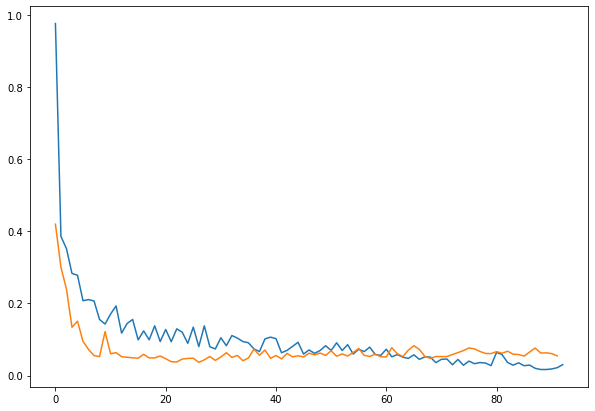

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(error)), error)
plt.plot(np.arange(len(test_error)), test_error)
plt.show()

In [ ]:
predicted = []
with torch.no_grad():
    for data in tqdm(testloader):
        img_np, mask, label = data
        img = img_np.to(device=device, dtype=torch.float32)
        output = model(img)
        output = torch.sigmoid(torch.squeeze(output,1))
        full_mask = output.cpu().numpy()
        predicted.append([img_np, full_mask>0.5, mask, label])

100%|██████████| 27/27 [00:02<00:00, 11.01it/s]


In [ ]:
np.array(predicted).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(27, 4)

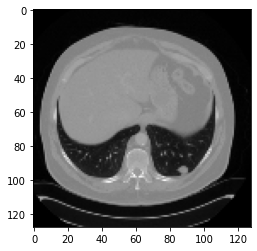

In [ ]:
plt.imshow(predicted[10][0][0][0].numpy(),cmap = "gray")

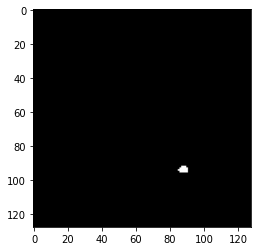

In [ ]:
plt.imshow((predicted[10][1][0]*1),cmap = "gray")

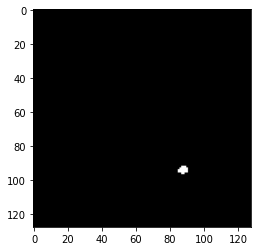

In [ ]:
plt.imshow((predicted[10][2][0]),cmap = "gray")

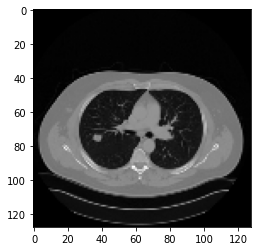

In [ ]:
plt.imshow(predicted[1][0][0][0].numpy(),cmap = "gray")

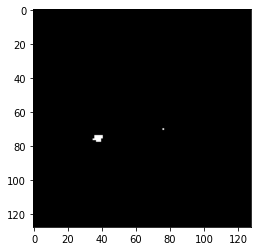

In [ ]:
plt.imshow((predicted[1][1][0]*1),cmap = "gray")

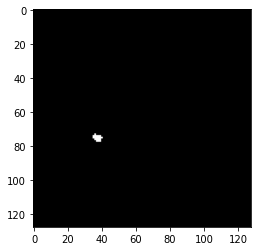

In [ ]:
plt.imshow((predicted[1][2][0]),cmap = "gray")

In [ ]:
torch.max(mask[0])

tensor(1)

In [ ]:
np.max(predicted[1][1][0]*1)

1

In [ ]:
np.min((predicted[1][1][0]))

False

In [ ]:
np.min(predicted[10][1][0])

False

In [ ]:
def dice_coeff(pred, target):
    m1 = np.array(pred).flatten()
    m2 = np.array(target).flatten()
    #smooth = 1.
    #num = pred.size(0)
    #m1 = pred.view(num, -1).float()  # Flatten
    #m2 = target.view(num, -1).float()  # Flatten
    intersection = np.sum(m1 * m2)

    return (2. * intersection ) / (m1.sum() + m2.sum() )

In [ ]:
dice_coeff(predicted[1][1][0]*1, predicted[1][2][0])

0.8421052631578947

In [ ]:
dice_coeff(predicted[10][1][0]*1, predicted[10][2][0])

0.926829268292683

In [ ]:
dices = []
for i in range(len(predicted)):
  dices.append(dice_coeff(predicted[i][1][0]*1, predicted[i][2][0]))

In [ ]:
np.mean(dices)

0.7340510827280878